# Variational Autoencoder

The goal of this tutorial is to break down all the parts of the variational autoencoder and discuss them from fundamentals.

## Brief Review: Learning Distributions

Suppose we have samples from an (unknown) underlying distribution $w_i \sim p_D(w)$, and we want to learn what $p_D(w)$ is.

  - This problem is extremely general, and many learning problems fall under this viewpoint. Take $w = y|x$, then this would be a supervised learning problem of learning $p_D(y|x)$.

  - We would want to approximate the true distribution $p_D(w)$ with a parametric approximation $q_\theta(w)$. Any objective between distributions can be used. A notable one is the (forward) __KL divergence__ $KL(p_D(w)\;||\; q_\theta(w))$.


### Relating back to what we know...
In the special case of a classification problem with $K$ classes, this objective is the _cross entropy_ (CE) loss.

$$
\min_\theta KL(p_D(y|x)\;||\; q_\theta(y|x)) = \underbrace{\mathbb{E}_{t \sim p_D(y|x)}[\log p_D(t|x) - \log q_\theta(t|x)]}_{\text{definition}} = \underbrace{\mathbb{E}_{t \sim p_D(y|x)}[\log p_D(t|x)]}_{\text{no effect on optimization of $\theta$}} - \mathbb{E}_{t \sim p_D(y|x)} [\log q_\theta(t|x)]
$$

The first term does not depend on $\theta$, and we evaluate the second term with a single sample to obtain the CE loss:

$$
-\mathbb{E}_{t \sim p_D(y|x)} [\log q_\theta(t|x)] = - \log q_\theta(t|x)
$$

### More generally...

More generally, if we just want to learn an approximate distribution $q_\theta(w)$ to $p_D(w)$, many problems arise.

1. __Model constraint.__ $q_\theta$ needs to be __normalized__, ie. $\int_w q_\theta(w) dw = 1$. In classification, $w = y|x$ is a discrete distribution with only $K$ possible values, so we can just enforce the sum to be 1 (e.g. by using softmax).

2. __Problem knowledge.__ (Partial) information about $p_D(w)$ can come in many forms. Typical scenarios are (i) i.i.d. samples can be obtained from $p_D$, (ii) $p_D$ can be evaluated at any value of $w$, perhaps up to a normalizing constant. It may be that you only have (i) but not (ii) or vice-versa. _The training objective for $q_\theta$ needs to take into account what information is available._

#### Parameterizing q to always be normalized.

One way to tackle the normalization problem is to output the _statistics_ of a known distribution instead of the probability density function itself. e.g. if we take

$$q_\theta(w) = \mathcal{N}(\mu_\theta(w), \sigma^2_\theta(w))$$

then we can model $q_\theta(w)$ by having a neural network that takes a value $w$ and outputs $\mu_\theta(w)$ and $\sigma_\theta(w)$.

# Variational Inference

Variational inference can be used to approximate an unnormalized density $\tilde{p}(z) = \frac{p(z)}{C}$ with a learned distribution $q_\theta(z)$.

### Motivation

The main application (and why it's referred to as inference) is to learn an approximation to the conditional distribution $p(z|x)$ when we only have access to the joint distribution $p(z,x)=p(z)p(x|z)$. 

Bayes rule:
$$
\underbrace{p(z|x)}_{\text{posterior}} = \frac{p(x|z)p(z)}{p(x)} \propto \underbrace{p(x|z)}_{\text{likelihood}}\underbrace{p(z)}_{\text{prior}}
$$

Trying to figure out what the posterior should be given the likelihood and prior is an inference problem.

This is in the same form as
$$
p(z) = \frac{\tilde{p}(z)}{C}
$$
if we fix the variable $x$, which means we are trying to learn the posterior $p(z|x)$.

The "variational" part of the name comes from approximating the true distribution $p(z|x)$ with an approximate (a.k.a. "variational") distribution $q_\theta(z)$.

### Training Objective: _Forward_ KL

We want an objective such that the minmizer is $q_\theta(z) = p(z)$.

Since we only have an unnormalized density $\tilde{p}(z)$ (that we can evaluate at any of $z$), a natural objective is the _forward_ KL

$$
L(\theta) := KL(q_\theta\;||\;p) = \mathbb{E}_{z\sim q(z)}[\log q(z) - \log p(z)] = \mathbb{E}_{z\sim q(z)}[\log q(z) - \log \tilde{p}(z) + \log C]
$$

The constant $C$ does not affect the optimization of $L(\theta)$.

In [1]:
%matplotlib inline

import math
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from tqdm import tqdm

In [2]:
def normal_logprob(z, mean, log_std):
    mean = mean + torch.tensor(0.)
    log_std = log_std + torch.tensor(0.)
    c = torch.tensor([math.log(2 * math.pi)]).to(z)
    inv_sigma = torch.exp(-log_std)
    tmp = (z - mean) * inv_sigma
    return -0.5 * (tmp * tmp + 2 * log_std + c)

def log_density_funnel(x):
    x1, x2 = x[:, 0], x[:, 1]
    x2_logdensity = normal_logprob(x2, 0, np.log(1.35))
    x1_logdensity = normal_logprob(x1, 0, x2)
    return x2_logdensity + x1_logdensity

def plot_isocontours(ax, func, xlimits=[-3, 3], ylimits=[-5, 3], numticks=101, alpha=1.0, cmap=plt.get_cmap('viridis')):
    x = np.linspace(*xlimits, num=numticks)
    y = np.linspace(*ylimits, num=numticks)
    X, Y = np.meshgrid(x, y)
    pts = torch.from_numpy(np.concatenate([np.atleast_2d(X.ravel()), np.atleast_2d(Y.ravel())]).T)
    zs = torch.exp(func(pts)).detach().cpu().numpy()
    Z = zs.reshape(X.shape)
    ax.contour(X, Y, Z, alpha=alpha, cmap=cmap)
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_xlim(xlimits)
    ax.set_ylim(ylimits)

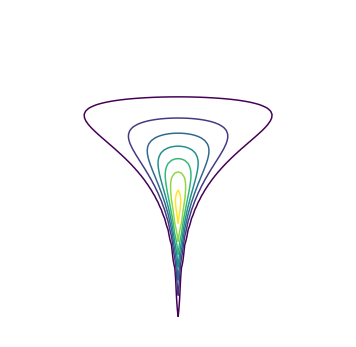

In [3]:
fig = plt.figure(figsize=(6, 6), facecolor='white')
ax = fig.add_subplot(111, frameon=False)
plot_isocontours(ax, log_density_funnel)

Here we try to fit this funnel-like distribution with a Gaussian distribution $q$.

In [4]:
# Model parameters.
mean = nn.Parameter(torch.randn(1, 2))
log_std = nn.Parameter(torch.randn(1, 2))

def q_logprob(x):
    return normal_logprob(x.float(), mean, log_std).sum(1)

# Objective is the forward KL: E_q[logq - logp].
def calculate_kl(logprob_func, n_samples):
    ###########################################
    # Note: Sample from Q, evaluate logQ - logP
    ###########################################
    samples = torch.randn(n_samples, 2).to(mean) * torch.exp(log_std) + mean
    logq = q_logprob(samples)
    logp = logprob_func(samples)
    return torch.mean(logq - logp)

Text(0.5,1,'After Training')

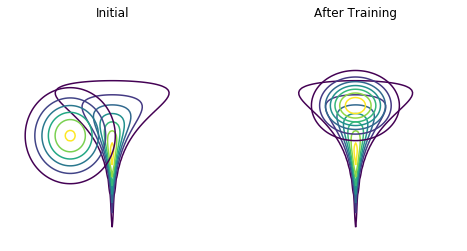

In [5]:
fig = plt.figure(figsize=(8, 4), facecolor='white')
ax = fig.add_subplot(121, frameon=False)
plot_isocontours(ax, log_density_funnel)
plot_isocontours(ax, q_logprob)
ax.set_title('Initial')

# Optimizer.
optimizer = torch.optim.Adam([mean, log_std], lr=1e-2)

# Training loop.
for i in range(3000):
    optimizer.zero_grad()
    kl = calculate_kl(log_density_funnel, 100)
    kl.backward()
    optimizer.step()
    
ax = fig.add_subplot(122, frameon=False)
plot_isocontours(ax, log_density_funnel)
plot_isocontours(ax, q_logprob)
ax.set_title('After Training')

## A Note on Forward vs reverse KL

KL divergence is asymmetric, implying $KL(q_\theta\;||\;p_D) \ne KL(p_D\;||\;q_\theta)$.
We may want to use either one depending on what we know about $p_D$.

If we only have samples from $p_D$, use _forward KL_: $KL(p_D\;||\;q_\theta)$. This objective is equivalent to performing "maximum likelihood".

If we can only evaluate $p_D$ up to a normalizing constant, use _reverse KL_: $KL(q_\theta\;||\;p_D)$.

## Latent-Variable Models (LVM)

Now instead of having a fixed $p(x|z)$, suppose we also want to learn this generative model $p_\theta(x|z)$.

#### Motivation
Instead of directly learning a distribution on $p(x)$, we may want to learn $p(x|z)$ because:

  - The latent variable $z$ is typically lower dimensional and may be more _interpretable_ or understandable. 
  - $p(x|z)$ can be _easier_ to model. (We can choose $z$ to be anything we want, including having no information about $x$, so then $p(x|z) = p(x) \;\forall z$. Thus directly learning $p(x)$ can be seen as a degenerate case of a latent variable model.)
  - The marginal distribution $p(x)$ can be more _flexible_.

Why not:
  
  - Access to $p(x)$ is now only implicitly defined using an integral $p(x) = \int p(x|z)p(z) dz$.

Let's go back to Bayes rule:

$$
p_\theta(z|x) = \frac{p_\theta(x|z)p(z)}{p_\theta(x)}
$$

Here we use $\theta$ to denote that the distribution depends on $\theta$ even if we're only directly parameterizing $p_\theta(x|z)$. We can no longer treat $p_\theta(x) = \int p_\theta(x|z)p(z) dz $ as a constant because it depends on the parameters $\theta$.

# Evidence Lower BOund (ELBO)

Ideally, we directly optimize based on $p_\theta(x)$, but this is hidden behind an expensive integral. Instead, the ELBO is typically used to train latent variable models by introducing a variational distribution $q(z)$.

The ELBO can be derived in many different ways. Here's a short one: take Bayes' rule and apply to both sides, (i) log, (ii) subtract $\log q(z)$, (iii) take expectation w.r.t. $q(z)$.

$$
\log p(z|x) = \log p(x|z) + \log p(z) - \log p(x)
$$

$$
\log p(z|x) - \log q(z) = \log p(x|z) + \log p(z) - \log p(x) - \log q(z)
$$

$$
\underbrace{\mathbb{E}_{z\sim q(z)} [ \log p(z|x) - \log q(z) ]}_{- \text{reverse KL}} = \underbrace{\mathbb{E}_{z\sim q(z)} [ \log p(x|z) + \log p(z) - \log q(z) ]}_{\text{ELBO}} - \log p(x)
$$

Re-arrange this, and we get

$$
\log p(x) = \text{ELBO(x)} + \underbrace{KL(q(z)\;||\;p(z|x))}_{\geq 0}
$$

$$
\text{ELBO(x)} := \mathbb{E}_{z\sim q(z)} [ \log p(x|z) + \log p(z) - \log q(z)]
$$

  - The ELBO is a function of $x$, so we can use $q(z|x)$ instead of $q(z)$.
  - Previously, we had an example where we minimized $KL(q(z)\;||\;p(z|x))$ for $p(x|z)$ and $x$ fixed. This is equivalent to maximizing the ELBO because $\log p_\theta(x)$ is constant.

When we want to train a generative model $p_\theta(x|z)$, maximizing the ELBO simultaneously:
  - maximizes $p_\theta(x)$, thus learning a generative model, and
  - minimizes $KL(q(z|x)\;||\;p(z|x))$, thus performing variational inference on $p(z|x)$.
  
The ELBO is a function of $x$, so if we have a dataset of samples $x_i$, we can maximize

$$
\sum_{i=1}^n ELBO(x_i)
$$

_Aside: This is equivalent to minimizing an upper bound on the forward KL divergence $KL(p_D(x)\;||\; p_\theta(x))$ with $n$ samples from $p_D$. Can you derive this equivalence?_

100%|██████████| 10000/10000 [00:16<00:00, 619.29it/s]


Final ELBO: -4.607


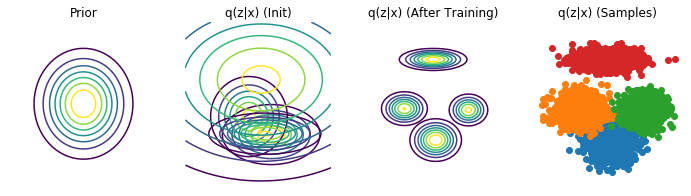

In [8]:
class VAE(nn.Module):
    
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(nn.Linear(2, 100), nn.ReLU(), nn.Linear(100, 4))
        self.decoder = nn.Sequential(nn.Linear(2, 100), nn.ReLU(), nn.Linear(100, 2))
    
    def elbo(self, x):
        # Get q(z|x). Get p(x|z). Kind of like an autoencoder.
        q_params = self.encoder(x)
        q_mean, q_logstd = q_params[:, :2], q_params[:, 2:]
        q_samples = torch.randn(x.shape[0], 2).to(q_mean) * torch.exp(q_logstd) + q_mean
        px_mean = self.decoder(q_samples)
        
        # Compute ELBO = logp(x|z) + logp(z) - logq(z)
        logqz = normal_logprob(q_samples, q_mean, q_logstd).sum(1)
        logpz = normal_logprob(q_samples, 0., 0.).sum(1)
        logpxz = normal_logprob(x, px_mean, 0.).sum(1)
        
        elbo = torch.mean(logpxz + logpz - logqz)
        return elbo

    
# We train on a dataset of just four points.
data = torch.tensor([
    [5, 5],
    [0, 5],
    [5, 0],
    [-5, -5],
]).float()

# VAE model.
model = VAE()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

# Just plotting code.
fig = plt.figure(figsize=(12, 3), facecolor='white')
ax = fig.add_subplot(141, frameon=False)
plot_isocontours(ax, lambda x: normal_logprob(x, 0., 0.).sum(1))
ax.set_title('Prior')
ax.set_ylim([-3, 3])
ax.set_xlim([-3, 3])

ax = fig.add_subplot(142, frameon=False)
q_params = model.encoder(data)
q_mean, q_logstd = q_params[:, :2], q_params[:, 2:]
for i in range(4):
    plot_isocontours(ax, lambda x: normal_logprob(x.float(), q_mean[i], q_logstd[i]).sum(1))
ax.set_title('q(z|x) (Init)')
ax.set_ylim([-3, 3])
ax.set_xlim([-3, 3])

# Training loop.
for _ in tqdm(range(10000)):
    optimizer.zero_grad()
    elbo = model.elbo(data)
    elbo.mul(-1).backward()
    optimizer.step()

# More plotting code.
ax = fig.add_subplot(143, frameon=False)
q_params = model.encoder(data)
q_mean, q_logstd = q_params[:, :2], q_params[:, 2:]
for i in range(q_mean.shape[0]):
    plot_isocontours(ax, lambda x: normal_logprob(x.float(), q_mean[i], q_logstd[i]).sum(1))
ax.set_title('q(z|x) (After Training)')
ax.set_ylim([-3, 3])
ax.set_xlim([-3, 3])

ax = fig.add_subplot(144, frameon=False)
for i in range(q_mean.shape[0]):
    samples = torch.randn(1000, 2).to(q_mean) * torch.exp(q_logstd[i][None]) + q_mean[i][None]
    ax.scatter(samples[:, 0].detach().numpy(), samples[:, 1].detach().numpy())
ax.set_title('q(z|x) (Samples)')
ax.set_ylim([-3, 3])
ax.set_xlim([-3, 3])
ax.set_yticks([])
ax.set_xticks([])

print('Final ELBO: {:.3f}'.format(elbo.item()))

## Normalizing Flows

Previously, we stuck to modeling using Gaussians because we know the normalization constant of a Gaussian distribution. Normalizing flows offer a more flexible way to tackle the normalization constant.

The change of variables applied to random variables:

$$
\log p(x) = \underbrace{\log p(x_0)}_{\text{simple distribution}} - \underbrace{\log \left| \det \frac{\partial T(x_0)}{\partial x_0} \right|}_{\text{automatically normalizes $p(x)$}}
$$

where $T$ is an __invertible__ transformation applied to samples from a simple distribution $p(x_0)$ into samples from $p(x)$. Here $p_\theta(x)$ is defined by the transformation $T_\theta$ itself.

An example of an invertible transformation is (in two dimensions):

$$T(z_0) = z_0$$
$$T(z_1) = z_1 + f(z_0)$$

Then the Jacobian is
$$
\begin{bmatrix}
1 & 0 \\
\frac{\partial f}{\partial z_0} & 1\\
\end{bmatrix}
$$

Since this is a triangular matrix, the determinant is the product of the diagonal elements, which is 1. The log determinant is 0. So for this type of transformation $p(x) = p(x_0)$ where $x = T(x_0)$. A transformation that doesn't change the probability density of the transformed sample is called _volume preserving_.

## Applying normalizing flows (NF) to variational inference.

Previously, we made the Gaussian assumption in two places:

  - In $q(z|x)$, in the variational inference part of the VAE.
  - In $p(x|z)$, in the generative model part of the VAE.

We could replace either with a NF, but we'll focus on using NF to express a more complex variational posterior, since this would help make training the generative model easier as well (because it can now have any posterior, not just ones easily approximated by a Gaussian).

To model $q(z|x)$ using a normalizing flow, we first define a simple distribution on $z_0$ then apply an invertible transformation to obtain:

$$
\log q(z|x) = \log q(z_0|x) - \log \left| \det \frac{\partial T(z_0)}{\partial z_0} \right|
$$

The second term is zero when using the volume preserving transformation from before.

100%|██████████| 10000/10000 [00:59<00:00, 166.69it/s]


Final ELBO: -4.083


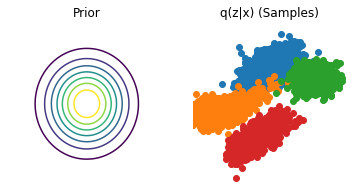

In [7]:
##!! The new parts of the code are commented with two hash symbols 
##!! and two exclaimation marks.

class VAE(nn.Module):
    
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(nn.Linear(2, 100), nn.Tanh(), nn.Linear(100, 4))
        self.decoder = nn.Sequential(nn.Linear(2, 100), nn.Tanh(), nn.Linear(100, 2))
        
        ##!! We use 10 series of invertible transformations.
        self.transforms = nn.ModuleList([
            nn.Sequential(nn.Linear(1, 20), nn.Tanh(), nn.Linear(20, 1)) for _ in range(10)
        ])
        
    def transform(self, z):
        ##!! Alternate dimensions for transformation.
        for i, transform in enumerate(self.transforms):
            if i % 2 == 0:
                z = torch.cat([z[:, 0:1], z[:, 1:2] + transform(z[:, 0:1])], dim=1)
            else:
                z = torch.cat([z[:, 0:1] + transform(z[:, 1:2]), z[:, 1:2]], dim=1)
        return z
    
    def elbo(self, x):
        # Get q(z|x). Get p(x|z). Kind of like an autoencoder.
        q_params = self.encoder(x)
        q_mean, q_logstd = q_params[:, :2], q_params[:, 2:]
        q_samples = torch.randn(x.shape[0], 2).to(q_mean) * torch.exp(q_logstd) + q_mean
        
        ##!! Compute log q(z_0) based on pre-transform samples.
        logqz = normal_logprob(q_samples, q_mean, q_logstd).sum(1)
        
        ##!! Transformed samples.
        q_samples = self.transform(q_samples)
        
        px_mean = self.decoder(q_samples)
        
        # Compute ELBO = logp(x|z) + logp(z) - logq(z)
        logpz = normal_logprob(q_samples, 0., 0.).sum(1)
        logpxz = normal_logprob(x, px_mean, 0.).sum(1)
        
        elbo = torch.mean(logpxz + logpz - logqz)
        return elbo

    
# We train on a dataset of just four points.
data = torch.tensor([
    [5, 5],
    [0, 5],
    [5, 0],
    [-5, -5],
]).float()

# VAE model.
model = VAE()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

# Just plotting code.
fig = plt.figure(figsize=(6, 3), facecolor='white')
ax = fig.add_subplot(121, frameon=False)
plot_isocontours(ax, lambda x: normal_logprob(x, 0., 0.).sum(1))
ax.set_title('Prior')
ax.set_ylim([-3, 3])
ax.set_xlim([-3, 3])
    
# Training loop.
for _ in tqdm(range(10000)):
    optimizer.zero_grad()
    elbo = model.elbo(data)
    elbo.mul(-1).backward()
    optimizer.step()

# More plotting code.
ax = fig.add_subplot(122, frameon=False)
for i in range(q_mean.shape[0]):
    samples = torch.randn(1000, 2).to(q_mean) * torch.exp(q_logstd[i][None]) + q_mean[i][None]
    samples = model.transform(samples)
    ax.scatter(samples[:, 0].detach().numpy(), samples[:, 1].detach().numpy())
ax.set_title('q(z|x) (Samples)')
ax.set_ylim([-3, 3])
ax.set_xlim([-3, 3])
ax.set_yticks([])
ax.set_xticks([])
print('Final ELBO: {:.3f}'.format(elbo.item()))